In [18]:
#--------------------------------------------------------------------------------
# Module 1: Loading pickled big boi data for GAN model
#--------------------------------------------------------------------------------
import os
import pandas as pd

# Ensure the directory "Processed data" exists before attempting to load the file
if os.path.exists("Processed data/data_encoded.csv"):
    data_encoded = pd.read_csv("Processed data/data_encoded.csv")
else:
    print("The CSV file does not exist in the specified directory.")


#import pickle
#import os

# Ensure the directory "Processed data" exists before attempting to load the file
#if os.path.exists("Processed data/data_encoded.csv"):
 #   with open("Processed data/data_encoded.csv", "rb") as file:
  #      data_encoded = file
   #     print(data_encoded.columns)
#else:
 #   print("The pickled file does not exist in the specified directory.")


In [19]:
#--------------------------------------------------------------------------------
# Module 2: Define the Generator model
#--------------------------------------------------------------------------------

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Dropout, GaussianNoise

# Define the size of the random noise input (latent dimension)
latent_dim = 100
num_features = data_encoded.shape[1]

def build_generator():
    model = Sequential()

    model.add(Dense(64*8, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(GaussianNoise(0.1))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(64*16))
    model.add(LeakyReLU(alpha=0.2))
    model.add(GaussianNoise(0.1))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(64*32))
    model.add(LeakyReLU(alpha=0.2))
    model.add(GaussianNoise(0.1))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(num_features, activation='sigmoid'))

    return model

generator = build_generator()
generator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 512)               51712     
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 512)               0         
                                                                 
 gaussian_noise_6 (Gaussian  (None, 512)               0         
 Noise)                                                          
                                                                 
 batch_normalization_12 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                                 
 dropout_12 (Dropout)        (None, 512)               0         
                                                                 
 dense_17 (Dense)            (None, 1024)             

In [20]:
#--------------------------------------------------------------------------------
# Module 3: Define the Discriminator model
#--------------------------------------------------------------------------------

from tensorflow.keras.regularizers import l2

def build_discriminator():
    model = Sequential()

    model.add(Dense(64*32, input_dim=num_features, kernel_regularizer=l2(0.01)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(64*16, kernel_regularizer=l2(0.01)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(64*8, kernel_regularizer=l2(0.01)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(1, activation='sigmoid'))

    return model

discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 2048)              16951296  
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 2048)              0         
                                                                 
 batch_normalization_15 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                                 
 dropout_15 (Dropout)        (None, 2048)              0         
                                                                 
 dense_21 (Dense)            (None, 1024)              2098176   
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 1024)              0         
                                                      

In [21]:
#--------------------------------------------------------------------------------
# Module 4: Compile the Discriminator model
#   1. Using legacy Keras optimizer as i have an m2 chip macbook
#--------------------------------------------------------------------------------

from tensorflow.keras.optimizers.legacy import Adam

# Compile the Discriminator using the legacy optimizer ALTERNATIVES: 'mean_squared_error'
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0001, 0.5), metrics=['accuracy'])



In [22]:
#--------------------------------------------------------------------------------
# Module 5: Combined GAN Structure
#   OBS! Discriminator trainable=False as we dont wants to change its weights 
#   while during this initial generator training process.
#--------------------------------------------------------------------------------

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

# Ensure that the discriminator is not trainable when combined with the generator
discriminator.trainable = False

# Define the GAN's input (noise) and output (discriminator's probability for the generated sample)
gan_input = Input(shape=(latent_dim,))
generated_sample = generator(gan_input)
gan_output = discriminator(generated_sample)

# Define the combined GAN model
gan = Model(gan_input, gan_output)

# Compile the GAN using the same loss and optimizer as the discriminator
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0001, 0.5))

gan.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_4 (Sequential)   (None, 8276)              19648084  
                                                                 
 sequential_5 (Sequential)   (None, 1)                 19589121  
                                                                 
Total params: 39237205 (149.68 MB)
Trainable params: 19640916 (74.92 MB)
Non-trainable params: 19596289 (74.75 MB)
_________________________________________________________________


In [23]:
#--------------------------------------------------------------------------------
# Module 6: Training the GAN
#--------------------------------------------------------------------------------

import numpy as np

# Define training hyperparameters
epochs = 100 #500
batch_size = 256 #120
half_batch = batch_size // 2

# Lists to hold loss and accuracy values for plotting after training
d_losses = []
d_accuracies = []
g_losses = []

for epoch in range(epochs):

    # ---------------------
    #  Train Discriminator
    # ---------------------
    
    # Select a random half batch of real samples
    idx = np.random.randint(0, data_encoded.shape[0], half_batch)
    real_samples = data_encoded.iloc[idx].values.astype('float32')

    # Generate half batch of fake samples
    noise = np.random.normal(0, 1, (half_batch, latent_dim)).astype('float32')
    fake_samples = generator.predict(noise).astype('float32')

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(real_samples, np.ones((half_batch, 1)).astype('float32'))
    d_loss_fake = discriminator.train_on_batch(fake_samples, np.zeros((half_batch, 1)).astype('float32'))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  Train Generator
    # ---------------------
    
    noise = np.random.normal(0, 1, (batch_size, latent_dim)).astype('float32')
    valid_y = np.ones((batch_size, 1)).astype('float32')
    
    # Train the generator
    g_loss = gan.train_on_batch(noise, valid_y)

    # Save losses and accuracy for plotting
    d_losses.append(d_loss[0])
    d_accuracies.append(100 * d_loss[1])
    g_losses.append(g_loss)

    # Print the progress
    print(f"{epoch}/{epochs} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")

print("Training finished.")


4/4 [==============================] - 0s 9ms/step
0/100 [D loss: 53.99445915222168 | D accuracy: 47.65625] [G loss: 53.56569290161133]
4/4 [==============================] - 0s 8ms/step
1/100 [D loss: 53.46933364868164 | D accuracy: 52.734375] [G loss: 53.03722381591797]
4/4 [==============================] - 0s 7ms/step
2/100 [D loss: 52.908363342285156 | D accuracy: 50.78125] [G loss: 52.5261116027832]
4/4 [==============================] - 0s 13ms/step
3/100 [D loss: 52.428266525268555 | D accuracy: 50.78125] [G loss: 51.99665069580078]
4/4 [==============================] - 0s 9ms/step
4/100 [D loss: 51.96995735168457 | D accuracy: 50.0] [G loss: 51.55614471435547]
4/4 [==============================] - 0s 9ms/step
5/100 [D loss: 51.53807830810547 | D accuracy: 50.78125] [G loss: 51.14278793334961]
4/4 [==============================] - 0s 9ms/step
6/100 [D loss: 51.062705993652344 | D accuracy: 50.390625] [G loss: 50.65985870361328]
4/4 [==============================] - 0s 9ms/s

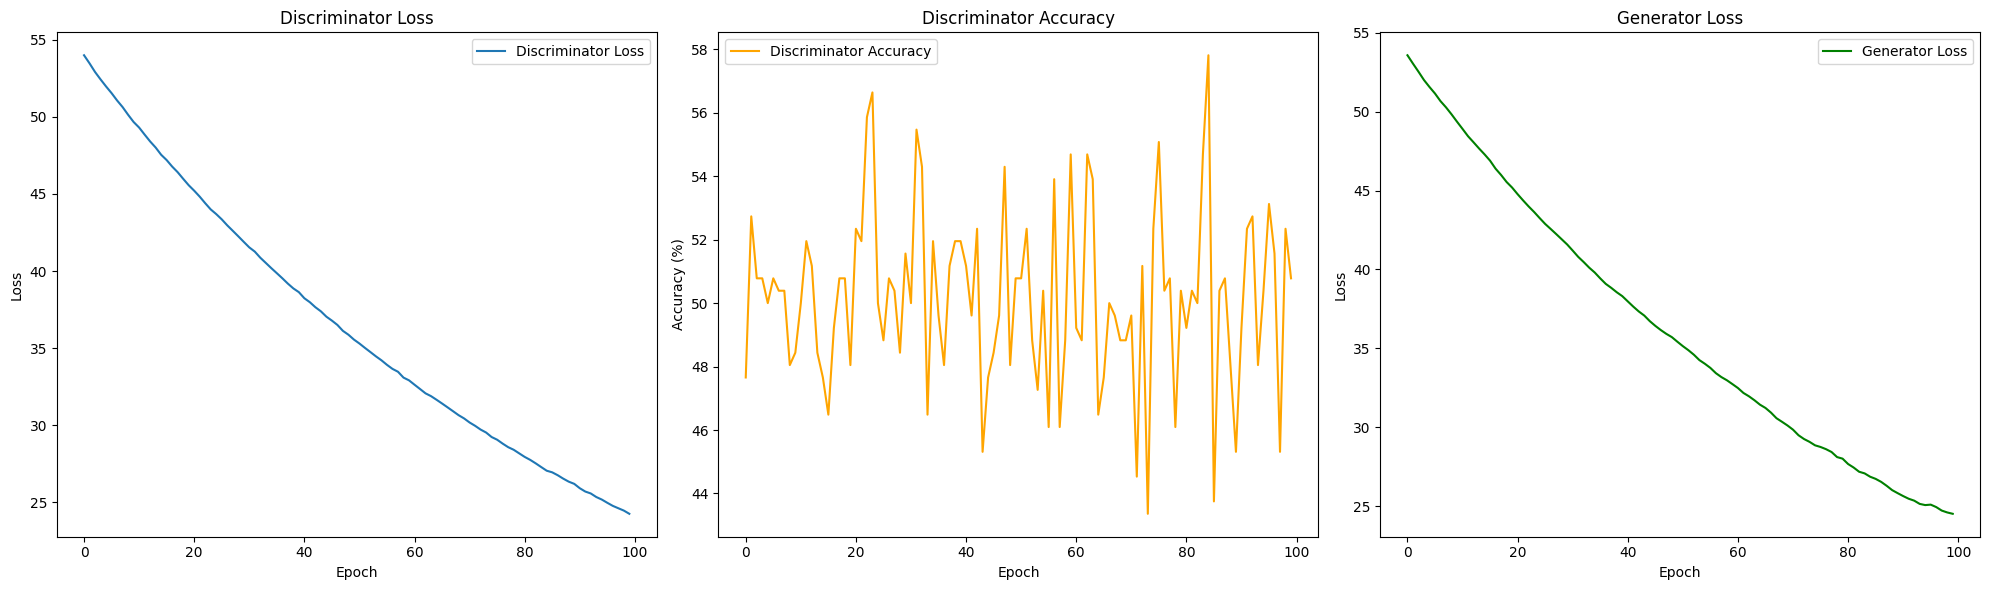

In [24]:
#--------------------------------------------------------------------------------
# Module 7: Visualize the Loss and Accuracy
#--------------------------------------------------------------------------------

import matplotlib.pyplot as plt

# Create a new figure for the plots
plt.figure(figsize=(20, 6))

# Plotting Discriminator Loss
plt.subplot(1, 3, 1)
plt.plot(d_losses, label='Discriminator Loss')
plt.title('Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Discriminator Accuracy
plt.subplot(1, 3, 2)
plt.plot(d_accuracies, label='Discriminator Accuracy', color='orange')
plt.title('Discriminator Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Plotting Generator Loss
plt.subplot(1, 3, 3)
plt.plot(g_losses, label='Generator Loss', color='green')
plt.title('Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [25]:
#--------------------------------------------------------------------------------
# Module 8: Synthetic Data Generation and Inverse Transformation
# 1. This module defines a function to generate synthetic data samples using a GAN.
# 2. It then inverses the one-hot encoding and normalization transformations to obtain
#    data in a format similar to the original input data. The resulting synthetic data 
#    is then printed for inspection. 
#--------------------------------------------------------------------------------

import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Model

# Load the original and encoded data
data = pd.read_csv("Cleaned Data/RT.IRS_Clean_v2.csv")
data_encoded = pd.read_csv("Processed data/data_encoded.csv")

# Define latent dimension used in the generator
latent_dim = 100  # This should match the latent dimension used in your generator

def generate_and_inverse_transform(generator, num_samples=20):
    # Generate synthetic data using the GAN
    noise = np.random.normal(0, 1, (num_samples, latent_dim))
    generated_samples = generator.predict(noise)

    # Convert generated samples to DataFrame
    generated_df = pd.DataFrame(generated_samples, columns=data_encoded.columns)

    # Inverse one-hot encoding to get original categorical columns
    categorical_columns = [col for col in data.columns if data[col].dtype == 'object']
    for original_col in categorical_columns:
        one_hot_cols = [col for col in generated_df.columns if col.startswith(original_col + "_")]
        if one_hot_cols:
            # Find the column with the highest value for each row
            max_col = generated_df[one_hot_cols].idxmax(axis=1)
            # Extract the category name and assign it to the original column
            generated_df[original_col] = max_col.apply(lambda x: x.replace(original_col + "_", ""))
            # Drop the one-hot columns
            generated_df.drop(one_hot_cols, axis=1, inplace=True)

    # Inverse normalization to get the original values of numerical columns
    numerical_columns = data_encoded.select_dtypes(include=['float64', 'int64']).columns
    scaler = RobustScaler()
    scaler.fit(data[numerical_columns])  # Fit the scaler to the original data
    generated_df[numerical_columns] = scaler.inverse_transform(generated_df[numerical_columns])

    # Ensure all columns from the original data are present in generated_df
    for col in data.columns:
        if col not in generated_df.columns:
            generated_df[col] = np.nan

    # Ensure the columns are in the same order as the original data
    generated_df = generated_df[data.columns]

    return generated_df

# Call the function and print synthetic data
synthetic_data = generate_and_inverse_transform(generator)


/var/folders/mg/_0j_111n661ccjxlkkzpn6xh0000gn/T/ipykernel_37863/1030822196.py:15: DtypeWarning: Columns (9,40,41,44,45,48) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("Cleaned Data/RT.IRS_Clean_v2.csv")


1/1 [==============================] - 0s 83ms/step


In [26]:
#--------------------------------------------------------------------------------
# Module 9: Generate Synthesized Data and Save to CSV
#--------------------------------------------------------------------------------

def save_synthesized_data(generator, num_samples=1000, output_file_path="Synthesized Data (GAN)/synthesized_data_GAN.csv"):
    # Generate synthetic data
    synthetic_data = generate_and_inverse_transform(generator, num_samples=num_samples)
    
    # Save the synthesized data to a CSV file
    synthetic_data.to_csv(output_file_path, index=False)
    print(synthetic_data.columns)
    
    print(f"Synthesized data generated and saved to {output_file_path}")

# Call the function to generate and save the synthetic data
save_synthesized_data(generator)


32/32 [==============================] - 0s 7ms/step
Index(['Event', 'Execution Timestamp', 'Dissemination Time', 'Cleared',
       'Collateralization', 'End-User Exception', 'Bespoke',
       'Block/Off facility', 'Execution Venue', 'UPI', 'Product',
       'Contract Type', 'Effective Date', 'Maturity Date', 'Upfront Payment',
       'Upfront Payment Currency', 'Upfront Payment Date',
       'Settlement Currency', 'Leg 1 Type', 'Leg 1 Fixed Rate',
       'Leg 1 Floating Index', 'Leg 1 Designated Maturity', 'Leg 1 Spread',
       'Leg 1 Day Count Convention', 'Leg 1 Notional',
       'Leg 1 Notional Currency', 'Leg 1 Payment Frequency',
       'Leg1 Reset Frequency', 'Leg 2 Type', 'Leg 2 Fixed Rate',
       'Leg 2 Floating Index', 'Leg 2 Designated Maturity', 'Leg 2 Spread',
       'Leg 2 Day Count Convention', 'Leg 2 Notional',
       'Leg 2 Notional Currency', 'Leg 2 Payment Frequency',
       'Leg 2 Reset Frequency', 'Embedded Option', 'Option Strike Price',
       'Option Type', 'O